In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out, d2d_kpi_veh, d2d_kpi_pax

from MaaSSim.decisions import dummy_False

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.notification_via_marketing = False # If True, marketing is active and agents regularly get notified.
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.20)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.=======================
params.d2d.m = 5 #for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 5
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
# Three changes in the setting based on the comments from Reviewers and supervisors:
# 1. we fix the demand, so travellers are always present and they don't choose between platform and PT
# 2. we fix the commission rate to 20% for baseline scenario to be inline with actual Uber operation 
# 3. we delete the greed stage from the baseline scenario to be inline with actual Uber operation 

In [7]:
# sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=dummy_False,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

sim, agent_new = MaaSSim.simulators.simulate_RL_main(input_agent=None,params=params, f_driver_out=S_driver_opt_out,f_trav_out=dummy_False,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
06-12-23 13:08:35-WARNING-Setting up 4h simulation at 2023-12-06 11:08:15 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands


ValueError: Argument(s) not recognized: {'lr': 0.001}

In [24]:
sim.res[4].veh_exp.INFORMED.value_counts()

True    200
Name: INFORMED, dtype: int64

In [8]:
sim.RL.to_csv('New_results/B1000_2.csv')
sim.RL.revenue.mean()

nan

In [9]:
df = pd.read_csv('New_results/R1000_1.csv')
df

,Unnamed: 0,state,action,revenue,reward,next_state,nP,nV,fare,comm_rate,discount,Marketing
0,0,[[0 0]],0,0.00000,0.00000,[[21 1]],21,1,1.2,0.15,0.0,True
1,1,[[21 1]],0,32.18496,32.18496,[[39 6]],39,6,1.2,0.20,0.0,True
2,2,[[39 6]],1,43.56612,43.56612,[[67 9]],67,9,1.2,0.15,0.0,True
3,3,[[67 9]],0,96.59248,96.59248,[[66 11]],66,11,1.2,0.20,0.0,True
4,4,[[66 11]],1,70.90578,70.90578,[[73 15]],73,15,1.2,0.15,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,[[269 23]],1,817.09902,817.09902,[[279 18]],279,18,1.2,0.45,0.0,False
996,996,[[279 18]],1,742.51008,742.51008,[[265 12]],265,12,1.2,0.40,0.0,False
997,997,[[265 12]],2,707.30768,707.30768,[[296 17]],296,17,1.2,0.40,0.0,False
998,998,[[296 17]],1,693.92288,693.92288,[[281 20]],281,20,1.2,0.35,0.0,False


In [10]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,state,action,revenue,reward,next_state,nP,nV,fare,comm_rate,discount,Marketing
0,[[0 0]],0,0.00000,0.00000,[[21 1]],21,1,1.2,0.15,0.0,True
1,[[21 1]],0,32.18496,32.18496,[[39 6]],39,6,1.2,0.20,0.0,True
2,[[39 6]],1,43.56612,43.56612,[[67 9]],67,9,1.2,0.15,0.0,True
3,[[67 9]],0,96.59248,96.59248,[[66 11]],66,11,1.2,0.20,0.0,True
4,[[66 11]],1,70.90578,70.90578,[[73 15]],73,15,1.2,0.15,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
995,[[269 23]],1,817.09902,817.09902,[[279 18]],279,18,1.2,0.45,0.0,False
996,[[279 18]],1,742.51008,742.51008,[[265 12]],265,12,1.2,0.40,0.0,False
997,[[265 12]],2,707.30768,707.30768,[[296 17]],296,17,1.2,0.40,0.0,False
998,[[296 17]],1,693.92288,693.92288,[[281 20]],281,20,1.2,0.35,0.0,False


In [11]:
for i in range(0,1000):
    if i<600:
        df.at[i,'comm_rate']=0.10
    if 600<=i<900:
        df.at[i,'comm_rate']=0.25
    if 900<=i<1000:
        df.at[i,'comm_rate']=0.5
        
df

,state,action,revenue,reward,next_state,nP,nV,fare,comm_rate,discount,Marketing
0,[[0 0]],0,0.00000,0.00000,[[21 1]],21,1,1.2,0.1,0.0,True
1,[[21 1]],0,32.18496,32.18496,[[39 6]],39,6,1.2,0.1,0.0,True
2,[[39 6]],1,43.56612,43.56612,[[67 9]],67,9,1.2,0.1,0.0,True
3,[[67 9]],0,96.59248,96.59248,[[66 11]],66,11,1.2,0.1,0.0,True
4,[[66 11]],1,70.90578,70.90578,[[73 15]],73,15,1.2,0.1,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
995,[[269 23]],1,817.09902,817.09902,[[279 18]],279,18,1.2,0.5,0.0,False
996,[[279 18]],1,742.51008,742.51008,[[265 12]],265,12,1.2,0.5,0.0,False
997,[[265 12]],2,707.30768,707.30768,[[296 17]],296,17,1.2,0.5,0.0,False
998,[[296 17]],1,693.92288,693.92288,[[281 20]],281,20,1.2,0.5,0.0,False


In [12]:
for i in range(0,1000):
    nP = sim.res[i].pax_exp.OUT_TOMORROW.value_counts().get(False, 0)
    nV = sim.res[i].veh_exp.OUT_TOMORROW.value_counts().get(False, 0)
    revenue = sim.res[i].pax_kpi.plat_revenue['sum']
    
    df.at[i,'nP']=nP
    df.at[i,'nV']=nV
    df.at[i,'revenue']=revenue

In [13]:
df['state'] = 0
df['action'] = 0
df['reward'] = 0
df['next_state'] = 0

df

,state,action,revenue,reward,next_state,nP,nV,fare,comm_rate,discount,Marketing
0,0,0,0.00000,0,0,15,3,1.2,0.1,0.0,True
1,0,0,11.36064,0,0,44,6,1.2,0.1,0.0,True
2,0,0,33.12052,0,0,55,2,1.2,0.1,0.0,True
3,0,0,41.92640,0,0,67,5,1.2,0.1,0.0,True
4,0,0,54.65768,0,0,98,4,1.2,0.1,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1108.81900,0,0,325,23,1.2,0.5,0.0,False
996,0,0,1117.17640,0,0,341,17,1.2,0.5,0.0,False
997,0,0,1136.25560,0,0,333,20,1.2,0.5,0.0,False
998,0,0,1105.80840,0,0,317,14,1.2,0.5,0.0,False


In [14]:
df.to_csv('New_results/B1000_2.csv')
df.revenue.mean()

973.9499659599998

In [14]:
(1083.59-976.68410684)/976.68410684

0.10945800429361667

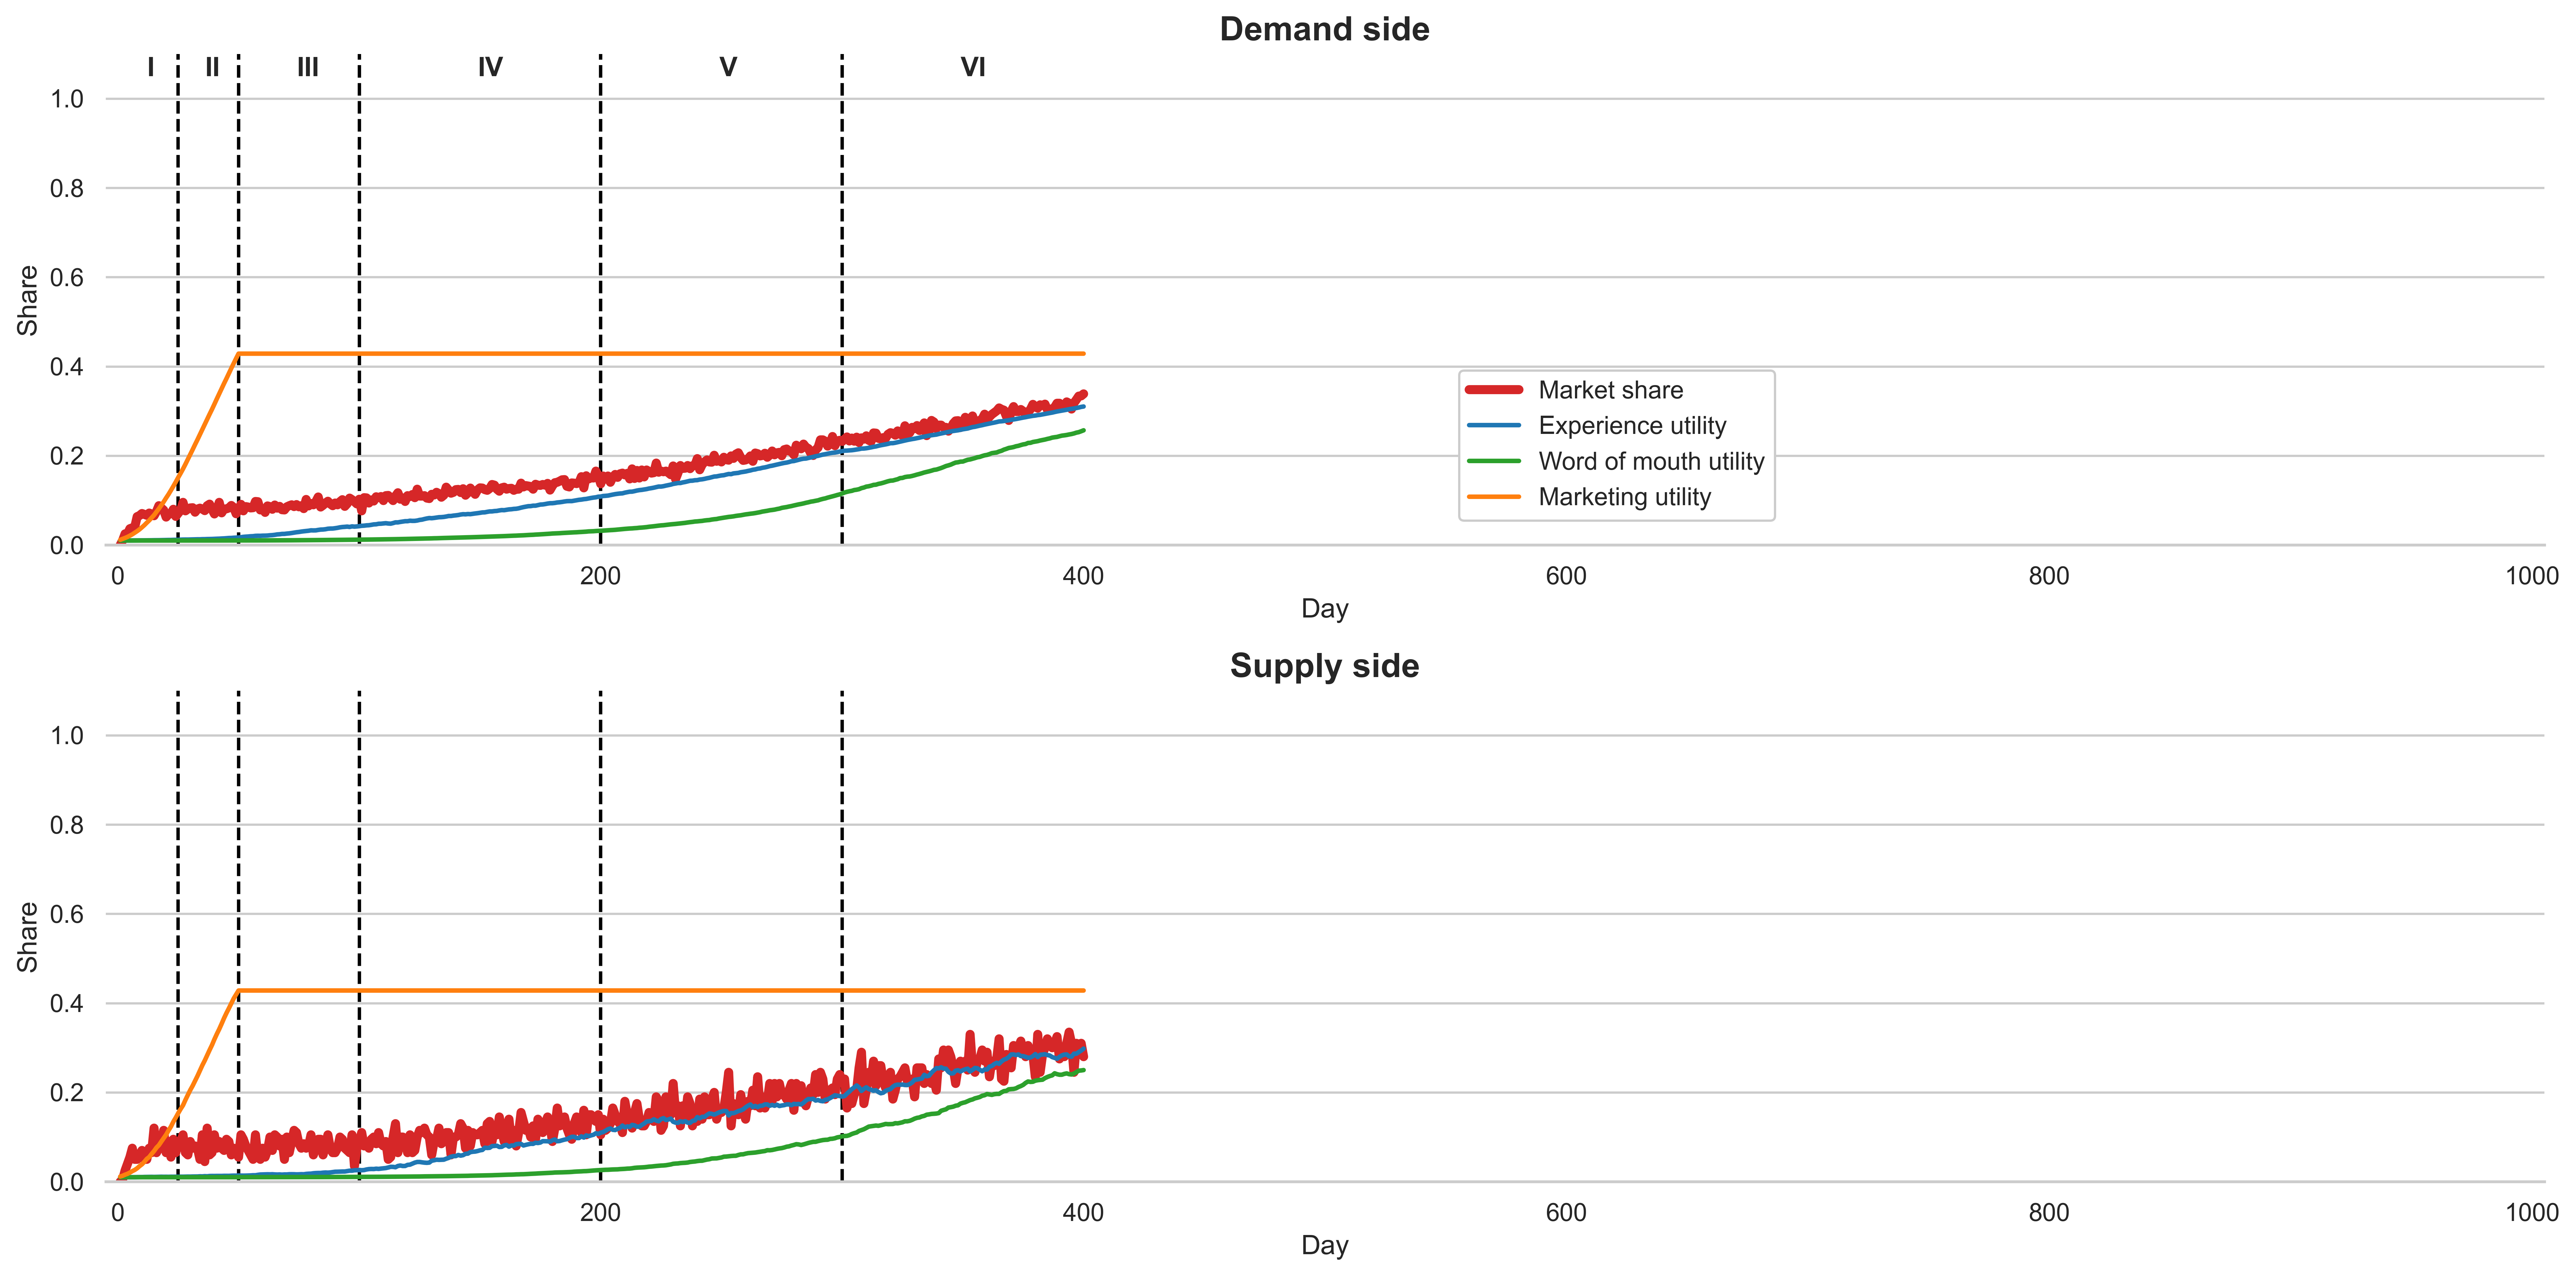

In [8]:
sim0 = sim
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].pax_exp.WOM_U.mean())
            ym.append(sim0.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].veh_exp.WOM_U.mean())
            ym.append(sim0.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,1005))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

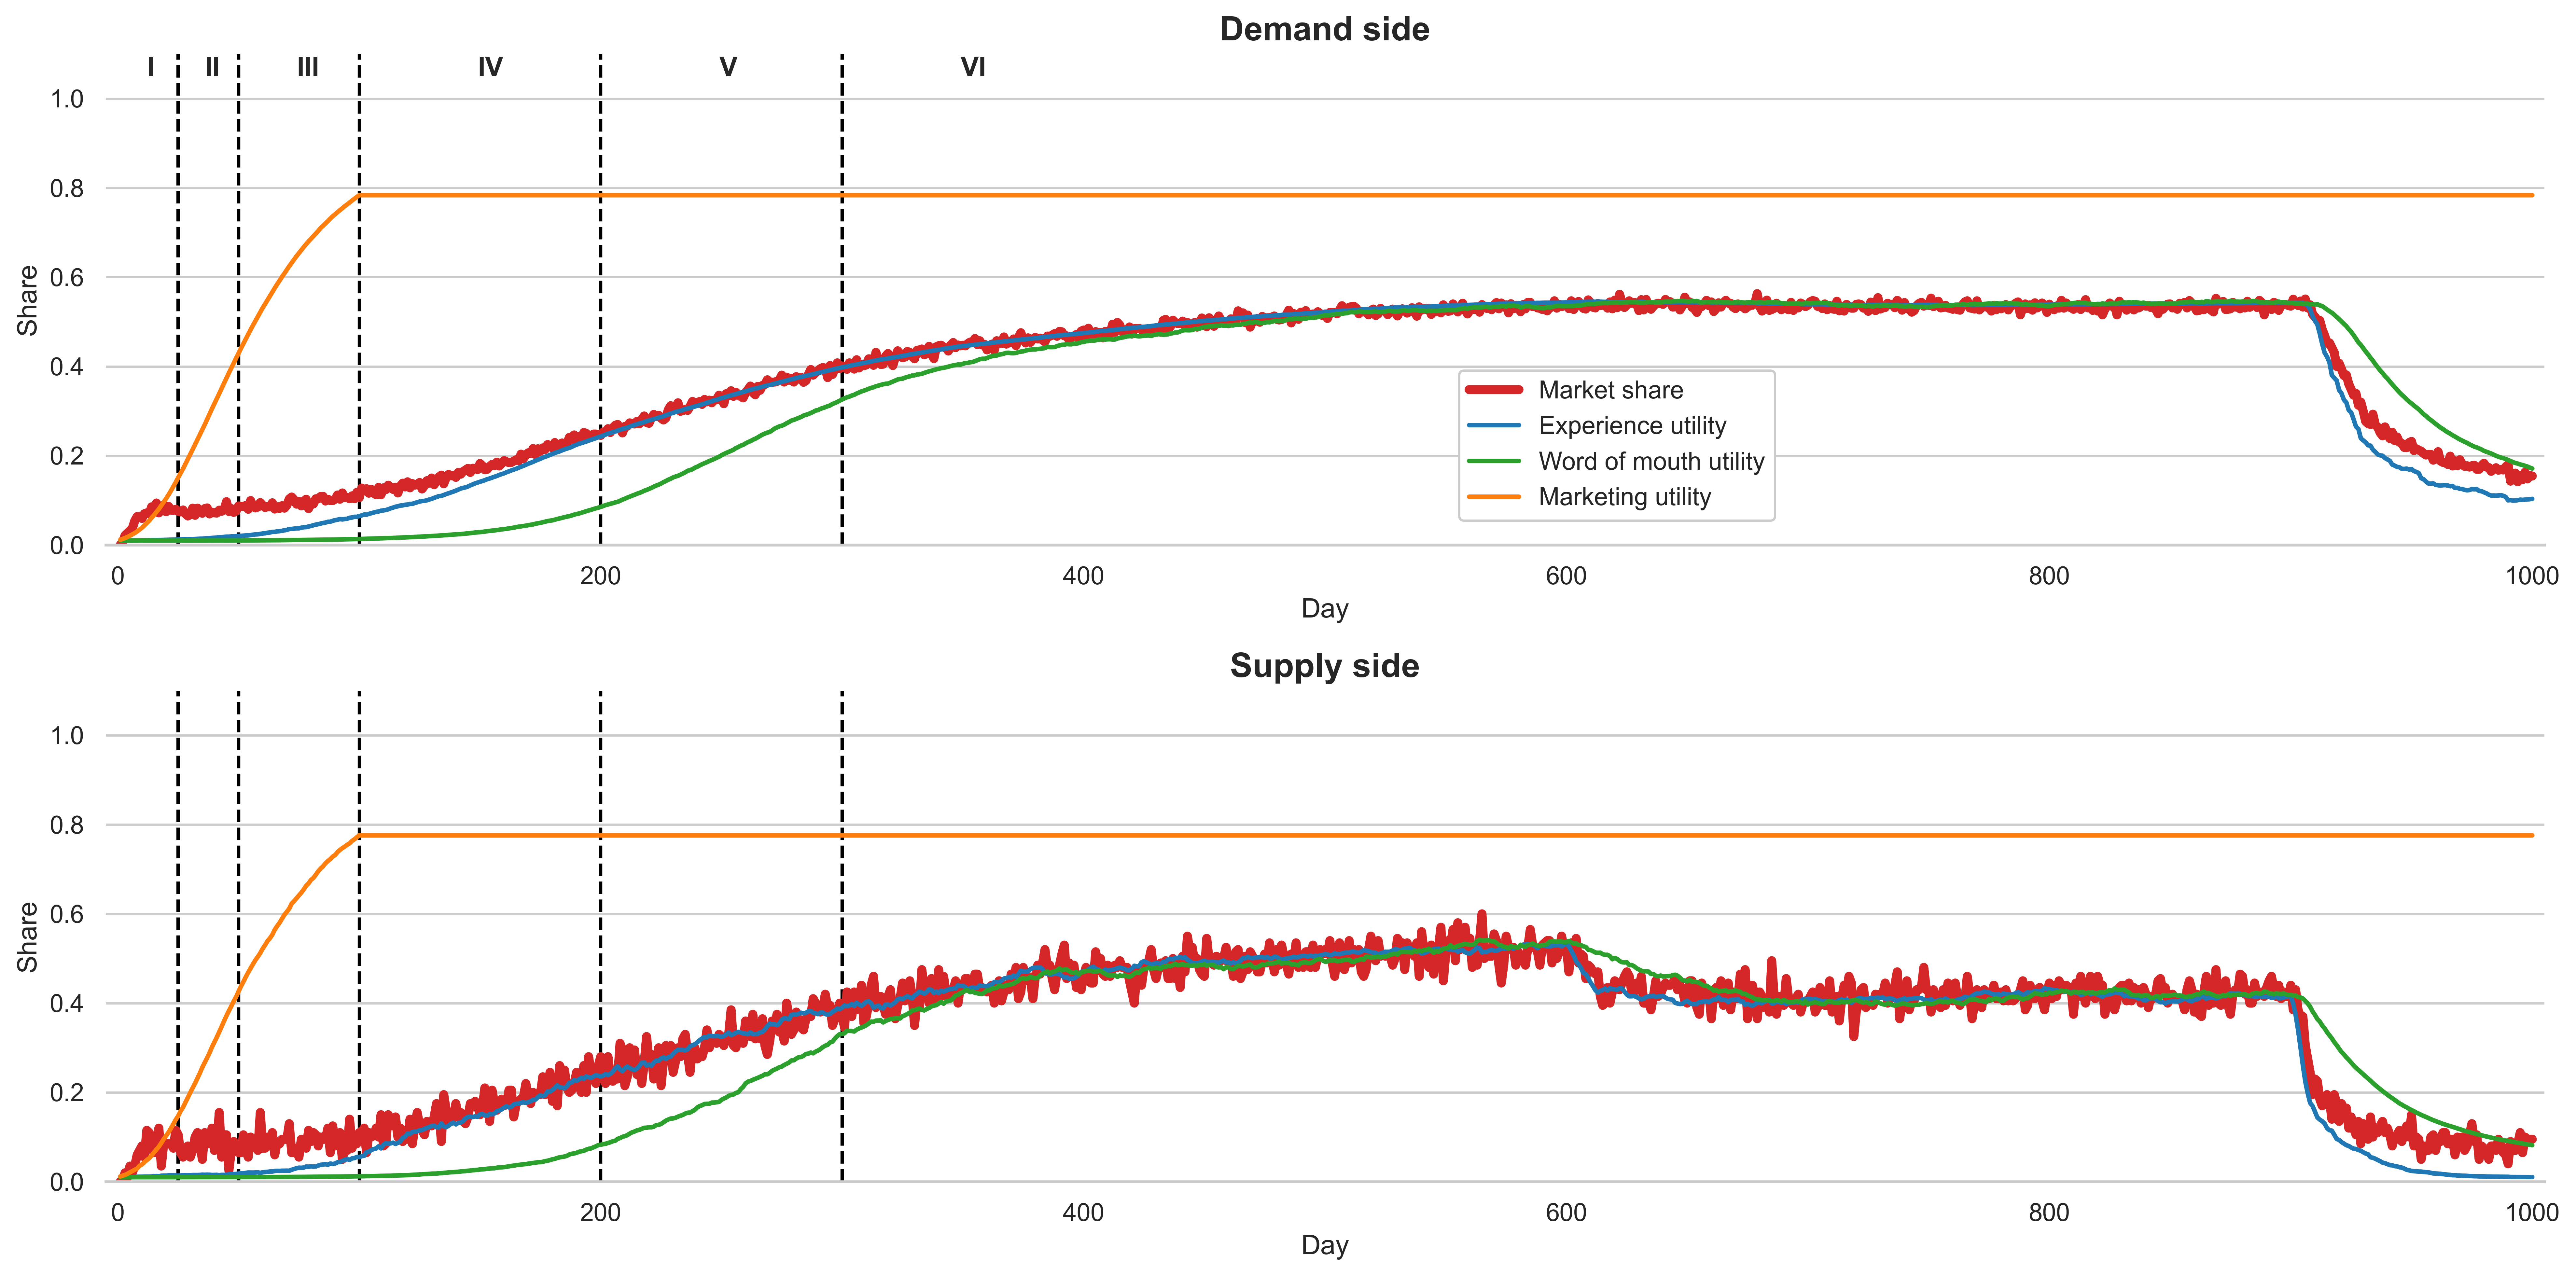

In [13]:
sim0 = sim
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].pax_exp.WOM_U.mean())
            ym.append(sim0.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].veh_exp.WOM_U.mean())
            ym.append(sim0.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,1005))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')